![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
1,2686.0,116.343261,125.273974,1.0,24.0,78.0,164.0,801.0
2,2733.0,215.251372,192.007843,1.0,49.0,172.0,321.0,873.0
3,2733.0,234.417124,197.151001,1.0,68.0,195.0,347.0,977.0
4,2734.0,198.988296,177.622409,1.0,51.0,161.0,294.0,948.0


Season es una variable categórica que adopta 4 valores dependiendo la estación del año: 1. Invierno, 2. Primavera, 3. Verano, 4. Otoño.
   * Invierno: Cuenta con el menor número de observaciones (2686) y menor promedio de renta de bicicletas (116) en comparación con el resto de estaciones. Se sugiere asimetría en los datos al comparar la media (116) y el percentil 50% (78). Así mismo su valor mínimo es de 1, máximo de 801 y desviación estandar de 125 (por encima del valor promedio) lo cual sugiere posible presencia de outliers.
   * Primavera: Cuenta con 2733 observaciones. En promedio se rentan 215 bicicletas en esta estación. Se sugiere asimetría en los datos al comparar la media (215) y el percentil 50% (172). Su valor mínimo es de 1 y máximo de 873 bicicletas rentadas lo cual pueude sugerir presencia de outliers.
   * Verano: Cuenta con 2733 observaciones y el mayor promedio de renta de bicicletas (234) en comparación con el resto de estaciones. Se sugiere asimetría en los datos al comparar la media (234) y el percentil 50% (195). Así mismo su valor mínimo es de 1, máximo de 977 y desviación estandar de 197 (la más alta de las 4 estaciones) lo cual sugiere posible presencia de outliers.
   * Otoño: Cuenta con 2734 observaciones. En promedio se rentan 177 bicicletas en esta estación. Se sugiere asimetría en los datos al comparar la media (177) y el percentil 50% (161). Su valor mínimo es de 1 y máximo de 948 bicicletas rentadas lo cual pueude sugerir presencia de outliers.

*Hallazgos adicionales :*
   * Como es de esperarse las estaciones de mayor frío (invierno y otoño) son los meses donde menos se rentan bicicletas y las de más calor (primavera y verano) es donde se rentan mayor número de bicicletas , esto denota posible estacionalidad en los datos.
   * Todas las estaciones presentan asimetría en los datos y posible presencia de outliers.

In [5]:
# Celda 1.2
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


Hour es una variable numérica que adopta 24 valores enteros correspondiente a un día entero. Examinando la media de renta de bicicletas, siendo muy intuitivo se encuentran 3 jornadas en el día:
   1. Inicialmente de las 0 a las 6am se identifica un patron en la media de 2 dígitos, acompañado con un valor mínimo de 1 y máximo de 283 bicis a las 0 horas.
   2. Luego de las 7am a las 10pm se mantienen los valores promedio con 3 dígitos. Cabe mencionar que dentro de este rango se presentan variaciones importantes que merecen analizarse posteriormente.
   3. Finalmente a las 11pm vuelve a descender el valor promedio de renta a 2 dígitos con 89, mínimo de 4 y máximo de 256.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

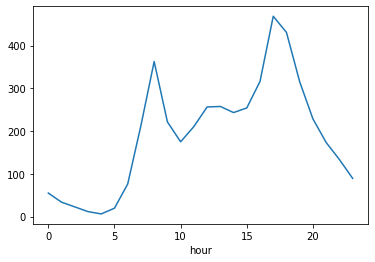

In [6]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

* Se identifican claramente 2 picos a las 8am y 5pm lo cual coincide típicamente con horarios laborales de ingreso y salida.

<AxesSubplot:title={'center':'Distribución de renta de bicicletas por hora del día en Invierno'}, xlabel='hour', ylabel='total'>

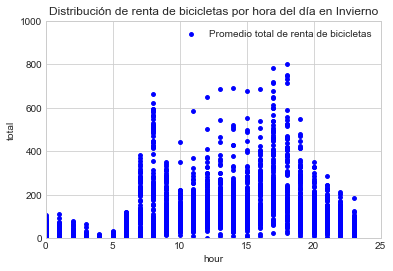

In [7]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 

%matplotlib inline
bikes_3 = bikes[(bikes["season"] == 1)]
plt.style.use('seaborn-whitegrid')
bikes_3.plot(kind='scatter', title = 'Distribución de renta de bicicletas por hora del día en Invierno', x='hour', y='total', label = "Promedio total de renta de bicicletas", color = "b", figsize = (6, 4), s=15, xlim=(0, 25), ylim=(0, 1000))

* En Invierno, la distribución de renta de bicicletas a lo largo del día mantiene el patrón general de distribución visto en la exploración de los datos, donde la mayor frecuencia se presenta en horarios de 7 a 21hrs.
Así mismo resalta que de manera generalizada, la mayor concentración de observaciones en todos los horarios del día se concentran por debajo de la media de 400. Destacan con mayor número de bicicletas rentadas dos horarios: 8hrs y 17 hrs, las cuales coinciden con entrada y salida de horarios de oficina, lo cual podría ser una hipótesis de principal driver de uso que sería interesante validar.  

<AxesSubplot:title={'center':'Distribución de renta de bicicletas por hora del día en Verano'}, xlabel='hour', ylabel='total'>

<Figure size 1152x864 with 0 Axes>

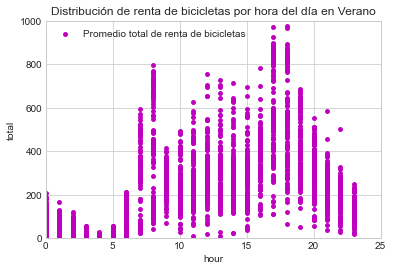

In [8]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 

%matplotlib inline
bikes_3 = bikes[(bikes["season"] == 3)]
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(16, 12))
bikes_3.plot(kind='scatter', title = 'Distribución de renta de bicicletas por hora del día en Verano', x='hour', y='total', label = "Promedio total de renta de bicicletas", color = "m", figsize = (6, 4), s=15, xlim=(0, 25), ylim=(0, 1000))

* Similar a la temporada de Invierno, en Verano se identifica un mayor uso de bicicletas en los horarios de la tarde. Especialmente los valores mínimos de renta son superiores a partir d elas 10hrs hasta las 20hrs. Así mismo se evidencia una mayor dispersión en los datos de manera generalizada. Especialmente resaltan los horarios de las 7, 8, 17 y 18 hrs como los horarios con mayor renta de bicicletas.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [9]:
# Celda 3
# Transformamos variable "Season" a dummies
bikes_2 = pd.get_dummies(bikes, columns = ['season'], drop_first= True)

# Se seleccionan variables
y = bikes_2['total']
X = bikes_2[['season_2', 'season_3', 'season_4', 'hour']]

# Se identifican observaciones con valores nulos
bikes.isna().sum()

# Se parte la muestra de test y train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# Se implementa modelo de regresión lineal
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
lr_y_estimado = lr.predict(X_test)

# Se calcula el R2
lr_r2 = lr.score(X_test, y_test)
print ("lr_r2:", str(lr_r2))

# Se calcula el MSE
lr_mse=np.average(np.square(lr_y_estimado-y_test))
print('MSE Regresión Lineal:', str(lr_mse))

lr_r2: 0.23145465514482966
MSE Regresión Lineal: 25988.201662266863


* El desempeño del modelo de Regresión Lineal no es alto (R2 = 22% y MSE= 24799). Al comparar la distribución de los datos, notamos diferentes patrones de distribución durante el día. Es probable que la rigidez de este modelo no sea el más adecuado para este caso y además se necesiten considerar más variables con el fin de encontrar una mejor predicción.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [10]:
# Celda 4

# Seguimos usando las variables dummies de season

# Definición de parámetros y criterios de parada
max_depth = 6
num_pct = 15
max_features = None
min_gain=0.001

# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
print ("giny:", str(gini(y)))


# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct=15):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

j, split, gain = best_split(X, y, 6)
print (j, split, gain)

# Definición de la función gini_impurity para calular la ganancia de una variable predictora j dado el punto de corte k

def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X, y, 5)
print("variable: ", str(j), ", split: ", str(split), ", ganancia: ", str(gain))


# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]
print ("y_l: ", str(y_l), ", y_r: ", str(y_r))

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Aplicación de la función tree_grow
tree_grow(X, y, level=0, min_gain=0.001, max_depth=6, num_pct=10)

tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

# Ejecución de función tree_predict
tree_predict(X, tree)

giny: -73018.14777226778


NameError: name 'gini_impurity' is not defined

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

DecisionTreeRegressor(max_depth=9, random_state=1)

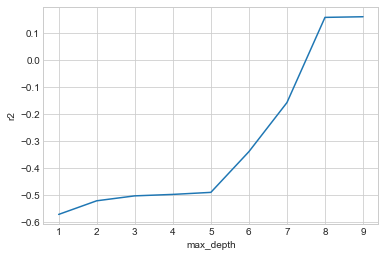

In [11]:
# Celda 5

# Sigo usando Bikes_2 con las variables dummies de Season.
# Se parte la muestra de test y train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

# Definición de parámetros y criterios de parada
max_depth = 8
num_pct = 20
max_features = None
min_gain=0.001

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1,10)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
r2_scores = []
mse_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeRegressor de la libreria sklearn
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    r2_scores.append(cross_val_score(clf, X, y, cv=15, scoring='r2').mean())
    mse_scores.append(cross_val_score(clf, X, y, cv=15, scoring='neg_mean_squared_error').mean())
    
# Gráfica max_depth versus R2
import matplotlib.pyplot as plt
plt.plot(max_depth_range, r2_scores)
plt.xlabel('max_depth')
plt.ylabel('r2')

# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(r2_scores, max_depth_range))[::-1][0]

# max_depth=9 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeRegressor(max_depth=9, random_state=1)
clf.fit(X, y)

In [12]:
# mse
print("dt_mse: ", str(sorted(zip(mse_scores, max_depth_range))[::-1][0]))

dt_mse:  (-15407.415560630445, 9)


In [13]:
# Impresión de resultados de desemepeño del árbol de decisión
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()

count    10.000000
mean      0.047027
std       0.990710
min      -2.635641
25%       0.075613
50%       0.440603
75%       0.537497
max       0.648350
dtype: float64

* El árbol de decisión obtuvo un R2 de 44% y MSE 15407, a pesar de que ambos valores mejoran con respecto al desempeño de la Regresión Lineal (R2 = 22% y MSE = 24799) aún el modelo no tiene un poder predictivo destacable. Es importante mencionar que sólo se están usando 2 variables, donde una de ellas (Season) se transformó a binaria lo cual beneficia el desempeño del árbol de regresión.
* Seguramente al considerar más variables estaremos obteniendo mejores resultados

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [53]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
#df.describe(include='all')

In [54]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']

# Encontramos que los datos se encuentran balanceados respecto a la variable de respuesta
y.mean()

0.5

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [48]:
# Celda 6

# Construcción Reg. Logística
# Se identifican observaciones con valores nulos
df.isna().sum()

# Se parte la muestra de test y train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# Se implementa modelo de regresión lineal
df_lr = linear_model.LogisticRegression()
df_lr.fit(X_train, y_train)
df_lr_y_estimado = df_lr.predict(X_test)

print ("Desempeño: Regresión Logística")
# Se calcula el R2
df_lr_r2 = df_lr.score(X_test, y_test)
print ("df_lr_r2: ", str(df_lr_r2))

# Se calcula el MSE
df_lr_mse=np.average(np.square(df_lr_y_estimado-y_test))
print('df_lr_mse: ', str(df_lr_mse))

#F1 Score
from sklearn import metrics
df_lr_f1 = metrics.f1_score(df_lr_y_estimado, y_test)
print("df_lr_f1= ", str(df_lr_f1))

Desempeño: Regresión Logística
df_lr_r2:  0.6166666666666667
df_lr_mse:  0.38333333333333336
df_lr_f1=  0.6134453781512605


In [52]:
print ("Desempeño: Árbol de decisión")
# Se parte la muestra de test y train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# Construcción Árbol de decisión
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1,10)

# Importación de modelos de sklearn

# Se crea modelo de arbol de clasificación
dt = DecisionTreeClassifier(max_depth=depth, random_state=1)
dt.fit(X_train, y_train)
dt_estimado = dt.predict(X_test)

# Se calcula el R2
dt_r2 = dt.score(X_test, y_test)
print ("dt_r2: ", str(dt_r2))

# Se calcula el MSE
dt_mse=np.average(np.square(dt_estimado-y_test))
print('dt_mse: ', str(dt_mse))

#F1 Score
print(f'dt_f1:  {f1_score(y_test, dt_estimado):.2f}')
print("- - - - - - - - - - - - - - - - - - - - - -")
print ("Notamos que ambos modelos tienen un desempeño muy similar donde el árbol supera ligeramente a la regresión logística principalmente en el accuracy, menor mse y mayor f1.")

Desempeño: Árbol de decisión
dt_r2:  0.6258333333333334
dt_mse:  0.37416666666666665
dt_f1:  0.63
- - - - - - - - - - - - - - - - - - - - - -
Notamos que ambos modelos tienen un desempeño muy similar donde el árbol supera ligeramente a la regresión logística principalmente en el accuracy, menor mse y mayor f1.


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [56]:
# Celda 7
accuracy = []
f1 = []

#100 árboles de decisión donde max_depth tome un valor de su elección

# Separación de variables predictoras (X) y variable de interés (y)

## Creación de 100 muestras de bootstrap
n_estimators = 100
np.random.seed(88)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

## Entrenamiento de 100 modelos con las 100 muestras boostrap

np.random.seed(88) 
seeds = np.random.randint(1, 9999, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=30, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    
## Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

## Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

## Desempeño - F1, Accuracy
from sklearn import metrics
m1_f1_VM = metrics.f1_score(y_pred, y_test)
f1.append(m1_f1_VM)
print("m1_f1_VM= ", str(m1_f1_VM))
m1_accuracy_VM = metrics.accuracy_score(y_pred, y_test)
accuracy.append(m1_accuracy_VM)
print("m1_accuracy_VM= ", str(m1_accuracy_VM))

# 100 árboles de decisión donde min_samples_leaf tome un valor de su elección

n_estimators = 100
np.random.seed(88)

n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

## Entrenamiento de 100 modelos con las 100 muestras boostrap

np.random.seed(88) 
seeds = np.random.randint(1, 9999, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=30, random_state=seeds[i], min_samples_leaf=3)
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
    
## Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

## Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

## Desempeño - F1, Accuracy
from sklearn import metrics
m2_f1_VM = metrics.f1_score(y_pred, y_test)
f1.append(m2_f1_VM)
print("m2_f1_VM= ", str(m2_f1_VM))
m2_accuracy_VM = metrics.accuracy_score(y_pred, y_test)
accuracy.append(m2_accuracy_VM)
print("m2_accuracy_VM= ", str(m2_accuracy_VM))

#100 regresiones logísticas

np.random.seed(88) 
seeds = np.random.randint(1, 9999, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = linear_model.LogisticRegression()
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
   
## Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df.head()

## Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

## Desempeño - F1, Accuracy
from sklearn import metrics
m3_f1_VM = metrics.f1_score(y_pred, y_test)
f1.append(m3_f1_VM)
print("m3_f1_VM= ", str(m3_f1_VM))
m3_accuracy_VM = metrics.accuracy_score(y_pred, y_test)
accuracy.append(m3_accuracy_VM)
print("m3_accuracy_VM= ", str(m3_accuracy_VM))

m1_f1_VM=  0.6538782318598833
m1_accuracy_VM=  0.6541666666666667
m2_f1_VM=  0.6622185154295246
m2_accuracy_VM=  0.6625
m3_f1_VM=  0.6182432432432433
m3_accuracy_VM=  0.6233333333333333


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [57]:
# Celda 8
# 100 árboles de decisión donde max_depth tome un valor de su elección
## Definición del modelo BaggingClassifier de la libreria sklearn
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=30), n_estimators=100, bootstrap=True,
                        random_state=55, n_jobs=-1, oob_score=True)

## Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

## Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

## Desempeño al hacer votación ponderada
from sklearn import metrics
m1_f1_VP = metrics.f1_score(y_pred, y_test)
f1.append(m1_f1_VP)
print ("m1_f1_VP", str(m1_f1_VP))
m1_accuracy_VP = metrics.accuracy_score(y_pred, y_test)
accuracy.append(m1_accuracy_VP)
print ("m1_accuracy_VP", str(m1_f1_VP))

# 100 árboles de decisión donde min_samples_leaf tome un valor de su elección
## Definición del modelo BaggingClassifier de la libreria sklearn
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=30, min_samples_leaf=3), n_estimators=100, bootstrap=True,
                        random_state=55, n_jobs=-1, oob_score=True)

## Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

## Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

## Desempeño al hacer votación ponderada
from sklearn import metrics
m2_f1_VP = metrics.f1_score(y_pred, y_test)
f1.append(m2_f1_VP)
print ("m2_f1_VP", str(m2_f1_VP))
m2_accuracy_VP = metrics.accuracy_score(y_pred, y_test)
accuracy.append(m2_accuracy_VP)
print ("m2_accuracy_VP", str(m2_f1_VP))

#100 regresiones logísticas
## Definición del modelo BaggingClassifier de la libreria sklearn
clf = BaggingClassifier(base_estimator=linear_model.LogisticRegression(), n_estimators=100, bootstrap=True,
                        random_state=55, n_jobs=-1, oob_score=True)

## Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

## Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

## Desempeño al hacer votación ponderada
from sklearn import metrics
m3_f1_VP = metrics.f1_score(y_pred, y_test)
f1.append(m3_f1_VP)
print ("m3_f1_VP", str(m3_f1_VP))
m3_accuracy_VP = metrics.accuracy_score(y_pred, y_test)
accuracy.append(m3_accuracy_VP)
print ("m3_accuracy_VP", str(m3_f1_VP))

m1_f1_VP 0.6572379367720466
m1_accuracy_VP 0.6572379367720466
m2_f1_VP 0.6432246998284734
m2_accuracy_VP 0.6432246998284734
m3_f1_VP 0.6181202370872142
m3_accuracy_VP 0.6181202370872142


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

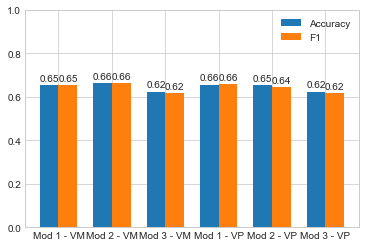

<Figure size 1152x864 with 0 Axes>

In [85]:
# Datos para los grupos A y B

# Configuración de las posiciones de las barras y su ancho
posiciones_barras = np.arange(len(accuracy))
ancho_barras = 0.35

# Crear el gráfico de barras agrupadas
fig, ax = plt.subplots()
ax.bar(posiciones_barras, accuracy, ancho_barras, label='Accuracy')
ax.bar(posiciones_barras + ancho_barras, f1, ancho_barras, label='F1')

# Agregar etiquetas a las barras
for i, valor in enumerate(accuracy):
    plt.text(i, valor + 0.01, str(round(valor,2)), ha='center', va='bottom')
for i, valor in enumerate(f1):
    plt.text(i + ancho_barras, valor + 0.01, str(round(valor,2)), ha='center', va='bottom')

# Configuración del gráfico
plt.xticks(posiciones_barras + ancho_barras / 2, ['Mod 1 - VM', 'Mod 2 - VM', 'Mod 3 - VM', 'Mod 1 - VP', 'Mod 2 - VP', 'Mod 3 - VP'])
plt.style.use('seaborn-whitegrid')
plt.legend()
ax.set_ylim(0, 1)
fig = plt.figure(figsize=(16, 12))
plt.show()

* El Modelo 2 (100 árboles con profundidad de 30 y min_leaf de 3) con votación mayoritaria y el Modelo 1 (100 árboles con profundidad de 30) empataron en desempeño con Accuracy y F1 de 0.66
* Los de 100 Reg. Logísticas tanto para Votación Mayoritaria como para Votación Ponderada obtuvieron los peores índices de desempeño.
* En conclusión los modelos de árboles de decisión en comparación con los modelos de Reg. Logística, suelen tener mejor desempeño de predicción. En este caso tanto la votación ponderada como la ponderada no obtuvieron mayores diferencias debido a que los OOB estuvieron equilibrados.